In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from lib.acoustic_model import AcousticModel
import lib.dataset as dataset
from lib.opt import optimize
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

checkpoint_dir = '_conv65536_pooling'
window = 65536

In [3]:
train_set = dataset.OrcaDataset(root='data', train=True, window=window,
                                translate=True, pitch_shift=5, jitter=1.0, stride=8192)
test_set = dataset.OrcaDataset(root='data', train=False, window=window)

Loaded dataset with 8074 datapoints
Loaded dataset with 25853 datapoints


In [4]:
class Model(AcousticModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def define_graph(self, debug=False):
        self.m = 1
        self.k = 512
        self.d = 1024
        self.stride = 1024
        self.regions = 1 + int(window - self.d)//self.stride
        
        self.wsin, self.wcos = self.create_filters(self.d,self.k)
        
        self.filters = filters = 128
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,(129,1),padding=(64,0),bias=False),nn.BatchNorm2d(32,1),nn.ReLU(True),
            nn.Conv2d(32,32,(129,1),padding=(64,0),bias=False),nn.BatchNorm2d(32,32),nn.ReLU(True),
            nn.AvgPool2d((32,1),stride=(32,1)),
            nn.Conv2d(32,filters,3,padding=1,bias=False),nn.BatchNorm2d(filters,32),nn.ReLU(True),
            nn.Conv2d(filters,filters,3,padding=1,bias=False),nn.BatchNorm2d(filters,filters),nn.ReLU(True)
        )
        
        fc_capacity = 128
        self.out = nn.Sequential(
            nn.Linear(16*self.regions*self.filters,fc_capacity,bias=False),nn.ReLU(True),
            nn.Linear(fc_capacity,self.m,bias=True)
        )
    
    def forward(self, x, y):
        zx = F.conv1d(x[:,None,:], self.wsin, stride=self.stride).pow(2) \
           + F.conv1d(x[:,None,:], self.wcos, stride=self.stride).pow(2)
        return torch.sigmoid(self.out(self.conv(torch.log(1+zx).unsqueeze(1)).view(-1,16*self.regions*self.filters)))
        #return self.out(self.conv(torch.log(1+zx).unsqueeze(1)).view(-1,16*self.regions*self.filters))

In [5]:
model = Model(checkpoint_dir, avg=.9, pytorch_init=True)
model.initialize()

conv.0.weight torch.Size([32, 1, 129, 1]) (4128)
conv.1.weight torch.Size([32]) (32)
conv.1.bias torch.Size([32]) (32)
conv.3.weight torch.Size([32, 32, 129, 1]) (132096)
conv.4.weight torch.Size([32]) (32)
conv.4.bias torch.Size([32]) (32)
conv.7.weight torch.Size([128, 32, 3, 3]) (36864)
conv.8.weight torch.Size([128]) (128)
conv.8.bias torch.Size([128]) (128)
conv.10.weight torch.Size([128, 128, 3, 3]) (147456)
conv.11.weight torch.Size([128]) (128)
conv.11.bias torch.Size([128]) (128)
out.0.weight torch.Size([128, 131072]) (16777216)
out.2.weight torch.Size([1, 128]) (128)
out.2.bias torch.Size([1]) (1)
Initialized graph with 17098529 parameters


In [6]:
optimize(model,train_set,test_set,learning_rate=3e-4,batch_size=64,workers=4,alg='Adam')

Initiating optimizer, 127 iterations/epoch.
avp_tr	avp_ts	iter	loss_tr	loss_ts	time	utime
42.32   20.83   0       0.684   0.671   15.02   14.74   
64.43   27.74   127     0.556   0.409   70.85   14.73   
Graceful Exit


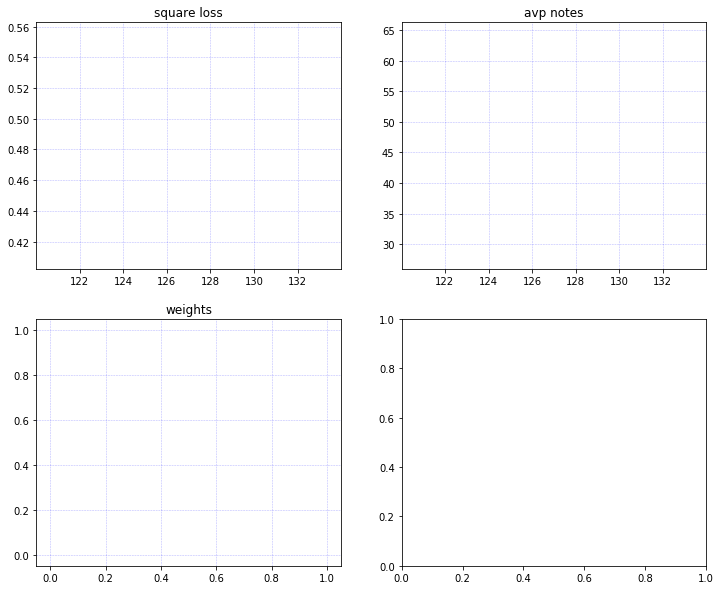

In [7]:
model.restore_checkpoint()
plt = media.PlotFormatter()
plt.plot('square loss',model.stats['loss_tr'][2],color='b')
plt.plot('square loss',model.stats['loss_ts'][2],color='g',share=True)
plt.plot('avp notes',model.stats['avp_tr'][2],color='b')
plt.plot('avp notes',model.stats['avp_ts'][2],color='g',share=True)
plt.plot('weights',model.sum_weights('beta'),color='g')
plt.show()

In [10]:
largestride_test_set = dataset.OrcaDataset(root='data', train=False, window=window, stride=8192)
test_loader = torch.utils.data.DataLoader(dataset=largestride_test_set,batch_size=128,drop_last=False,num_workers=1)
yhat,y = model.predict_all(test_loader)

Loaded dataset with 1615 datapoints


In [8]:
media.plot_pr_curve(y,yhat)

NameError: name 'y' is not defined

In [9]:
from sklearn.metrics import precision_recall_fscore_support
p,r,f,_ = precision_recall_fscore_support(y.ravel(),yhat.ravel()>.1,average='binary')
print(p,r,f)

NameError: name 'y' is not defined

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Get our predictions on the training set
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=128,drop_last=False,num_workers=1)
yhat_train, y_train = model.predict_all(train_loader)

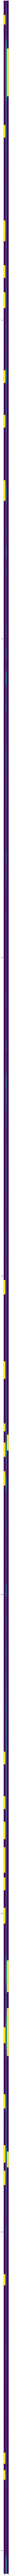

In [13]:
from lib.naiveBayes import plot
fs=44100
stride=8192
pWhaleBaseline=0.1
window=2
yHats = yhat
plot(yhat_train, train_set, y, yhat, window, fs, stride, pWhaleBaseline)